In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [16]:
df_temperatura=pd.read_csv('temperatura_ilha.csv')
print(df_temperatura.shape)
df_temperatura.head()

(3177, 4)


,Data,TEMP DO AR (º),TEMP MAX (ºC),TEMP MIN (ºC)
0,2023-10-31,2700.0,NaN,2200.0
1,2023-10-30,2300.0,NaN,1800.0
2,2023-10-30,2400.0,3100.0,NaN
3,2023-10-29,2700.0,NaN,2000.0
4,2023-10-29,2600.0,2800.0,NaN


In [17]:
#Excluindo valores em que não tem DATA
df_temperatura[df_temperatura['Data'].isnull()]
empty_indices = df_temperatura[df_temperatura['Data'].isnull()].index.tolist()
df_temperatura2=df_temperatura.drop(empty_indices)
print(df_temperatura2.shape)
df_temperatura2

(3159, 4)


,Data,TEMP DO AR (º),TEMP MAX (ºC),TEMP MIN (ºC)
0,2023-10-31,2700.0,NaN,2200.0
1,2023-10-30,2300.0,NaN,1800.0
2,2023-10-30,2400.0,3100.0,NaN
3,2023-10-29,2700.0,NaN,2000.0
4,2023-10-29,2600.0,2800.0,NaN
...,...,...,...,...
3168,2017-04-10,2200.0,2200.0,NaN
3169,2017-01-10,2600.0,NaN,1900.0
3170,2017-02-10,2100.0,2700.0,NaN
3171,2017-02-10,3100.0,NaN,1900.0


In [18]:
#Deixando na Escala Normal

colunas_numericas_tmp=['TEMP DO AR (º)','TEMP MAX (ºC)','TEMP MIN (ºC)']
df_temperatura2[colunas_numericas_tmp]=df_temperatura2[colunas_numericas_tmp].apply(lambda x: x / 100)
df_temperatura2.head()

,Data,TEMP DO AR (º),TEMP MAX (ºC),TEMP MIN (ºC)
0,2023-10-31,27.0,NaN,22.0
1,2023-10-30,23.0,NaN,18.0
2,2023-10-30,24.0,31.0,NaN
3,2023-10-29,27.0,NaN,20.0
4,2023-10-29,26.0,28.0,NaN


# Grafico TEMP MIN X DATA

In [19]:
df_tempmin=df_temperatura2.drop(['TEMP MAX (ºC)','TEMP DO AR (º)'],axis=1).dropna()
df_tempmin = df_tempmin.groupby('Data')['TEMP MIN (ºC)'].min().reset_index()
print(df_tempmin.shape)
df_tempmin

(1533, 2)


,Data,TEMP MIN (ºC)
0,2017-01-10,19.0
1,2017-02-10,19.0
2,2017-04-10,18.0
3,2017-05-10,22.0
4,2017-06-10,22.0
...,...,...
1528,2023-10-27,18.0
1529,2023-10-28,21.0
1530,2023-10-29,20.0
1531,2023-10-30,18.0


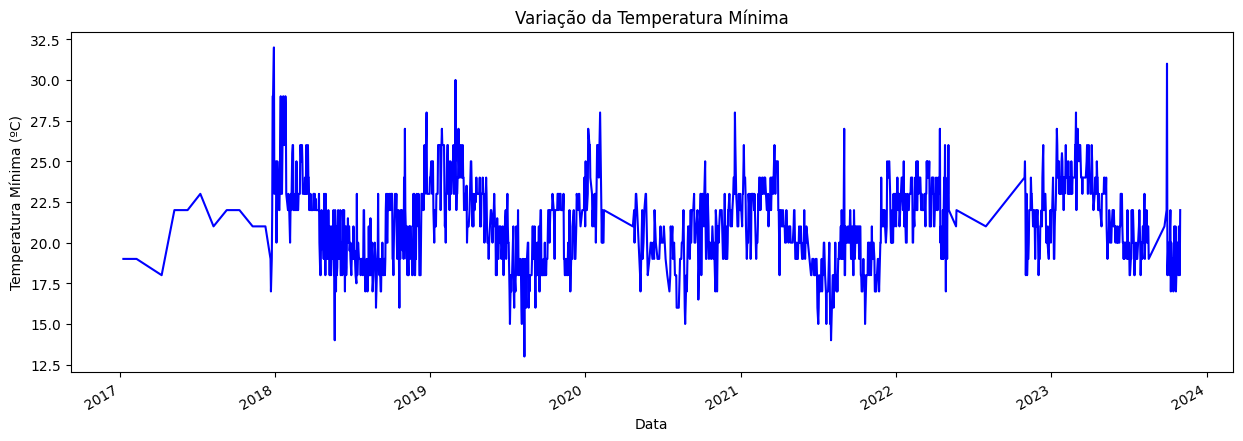

In [20]:
# Plotando os dados de treino e teste
df_tempmin['Data'] = pd.to_datetime(df_tempmin['Data'])
plt.figure(figsize=(15, 5))  # Tamanho reduzido para melhor visualização
plt.plot(df_tempmin['Data'], df_tempmin['TEMP MIN (ºC)'], color='b')  # Plotando treino
plt.xlabel('Data')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('Variação da Temperatura Mínima')

# Configurando os ticks do eixo x para que eles representem apenas os anos presentes nos dados
years = mdates.YearLocator()  # Localizador de anos
years_fmt = mdates.DateFormatter('%Y')  # Formatador para mostrar apenas o ano
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Melhorar a apresentação dos ticks do eixo x para evitar sobreposição
plt.gcf().autofmt_xdate()

plt.show()

# Grafico TEMP DO AR  X DATA

In [21]:
df_tempar=df_temperatura2.drop(['TEMP MAX (ºC)','TEMP MIN (ºC)'],axis=1).dropna()
df_tempar = df_tempar.groupby('Data')['TEMP DO AR (º)'].max().reset_index()
print(df_tempar.shape)
df_tempar

(1783, 2)


,Data,TEMP DO AR (º)
0,2017-01-10,26.0
1,2017-02-10,31.0
2,2017-03-10,25.0
3,2017-04-10,22.0
4,2017-05-10,23.0
...,...,...
1778,2023-10-27,22.0
1779,2023-10-28,24.0
1780,2023-10-29,27.0
1781,2023-10-30,24.0


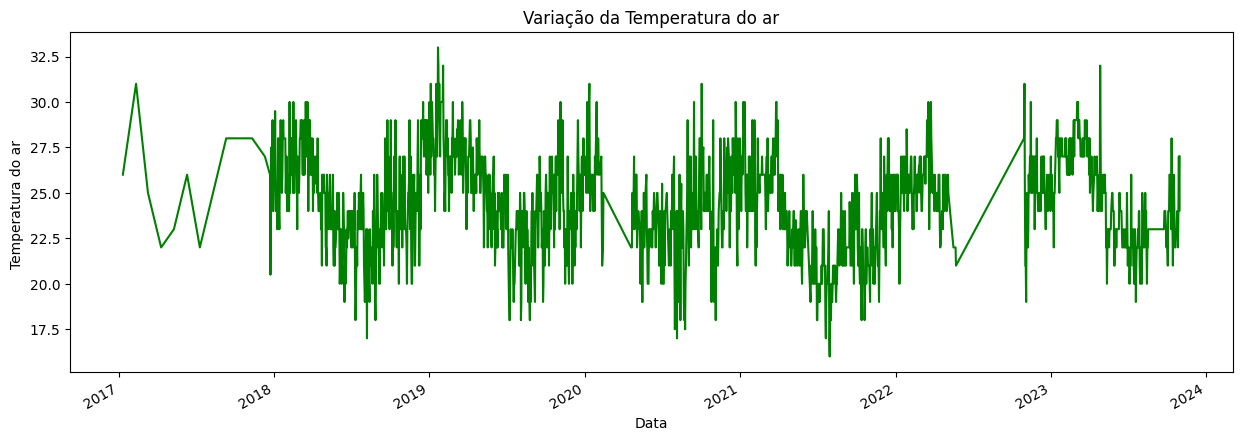

In [22]:
# Plotando os dados de treino e teste
df_tempar['Data'] = pd.to_datetime(df_tempar['Data'])
plt.figure(figsize=(15, 5))  # Tamanho reduzido para melhor visualização
plt.plot(df_tempar['Data'], df_tempar['TEMP DO AR (º)'], color='g')  # Plotando treino
plt.xlabel('Data')
plt.ylabel('Temperatura do ar ')
plt.title('Variação da Temperatura do ar')

# Configurando os ticks do eixo x para que eles representem apenas os anos presentes nos dados
years = mdates.YearLocator()  # Localizador de anos
years_fmt = mdates.DateFormatter('%Y')  # Formatador para mostrar apenas o ano
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Melhorar a apresentação dos ticks do eixo x para evitar sobreposição
plt.gcf().autofmt_xdate()

plt.show()

# Modelo ARIMA para TEMP MAX

Como so vamos usar o "temp max" eu retirei as duplicatas (duas ou mais medições diarias) e coloquei o valor maximo de cada dia!

In [23]:
df_tempmax=df_temperatura2.drop(['TEMP DO AR (º)','TEMP MIN (ºC)'],axis=1).dropna()
df_tempmax = df_tempmax.groupby('Data')['TEMP MAX (ºC)'].max().reset_index()
print(df_tempmax.describe())
df_tempmax.head()


       TEMP MAX (ºC)
count    1499.000000
mean       27.914610
std         3.604817
min        17.000000
25%        25.000000
50%        28.000000
75%        31.000000
max        41.000000


,Data,TEMP MAX (ºC)
0,2017-01-10,24.0
1,2017-02-10,27.0
2,2017-03-10,33.0
3,2017-04-10,22.0
4,2017-05-10,22.0


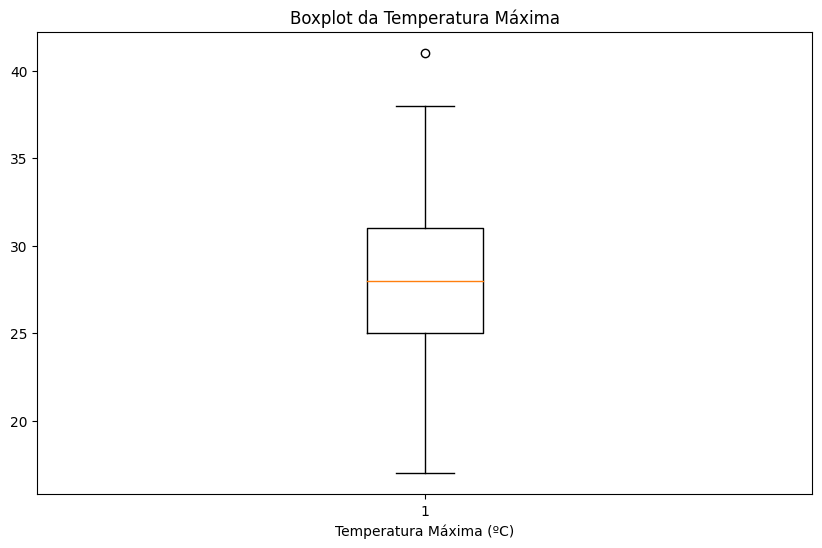

In [24]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_tempmax['TEMP MAX (ºC)'])
plt.title('Boxplot da Temperatura Máxima')
plt.xlabel('Temperatura Máxima (ºC)')
plt.show()

In [25]:
df_tempmax.isnull().sum()

Data             0
TEMP MAX (ºC)    0
dtype: int64

In [26]:
df_tempmax

,Data,TEMP MAX (ºC)
0,2017-01-10,24.0
1,2017-02-10,27.0
2,2017-03-10,33.0
3,2017-04-10,22.0
4,2017-05-10,22.0
...,...,...
1494,2023-10-26,26.0
1495,2023-10-27,25.0
1496,2023-10-28,17.0
1497,2023-10-29,28.0


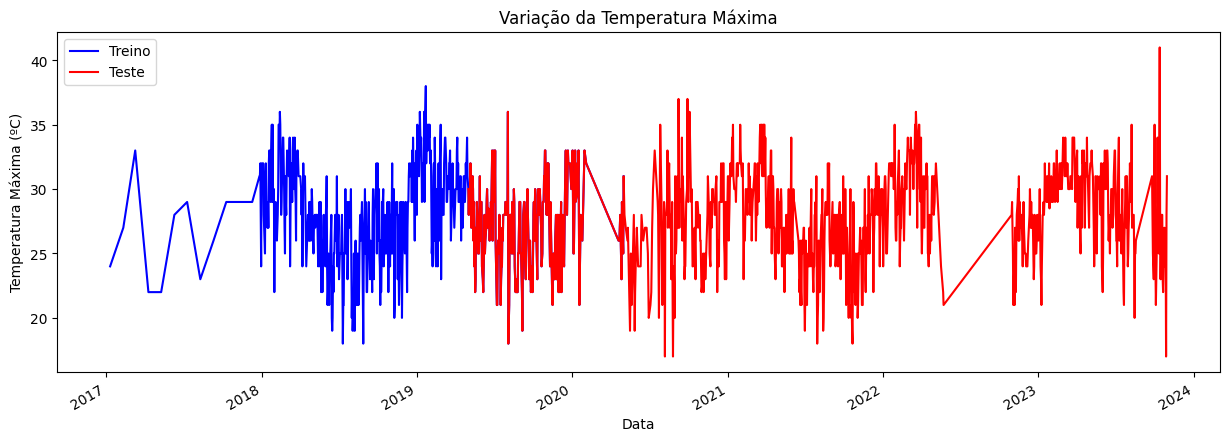

In [27]:


# Certifique-se de que 'Data' é um tipo datetime
df_tempmax['Data'] = pd.to_datetime(df_tempmax['Data'])

# Filtrando os dados conforme as datas fornecidas para treino e teste
temp_treino = df_tempmax[df_tempmax['Data'] <= '2020-05-01']
temp_teste = df_tempmax[df_tempmax['Data'] > '2019-05-01']

# Plotando os dados de treino e teste
plt.figure(figsize=(15, 5))  # Tamanho reduzido para melhor visualização
plt.plot(temp_treino['Data'], temp_treino['TEMP MAX (ºC)'], color='b')  # Plotando treino
plt.plot(temp_teste['Data'], temp_teste['TEMP MAX (ºC)'], color='r')  # Plotando teste
plt.legend(['Treino', 'Teste'])
plt.xlabel('Data')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('Variação da Temperatura Máxima')

# Configurando os ticks do eixo x para que eles representem apenas os anos presentes nos dados
years = mdates.YearLocator()  # Localizador de anos
years_fmt = mdates.DateFormatter('%Y')  # Formatador para mostrar apenas o ano
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Melhorar a apresentação dos ticks do eixo x para evitar sobreposição
plt.gcf().autofmt_xdate()

plt.show()

tem menos dados entre 2017 - 2018 , isso justifica ser menos "agressivo" no começo 

In [28]:

# Importando o módulo
from pmdarima.arima import auto_arima

# Instanciando e aplicando aos dados

auto_tmax= auto_arima(temp_treino['TEMP MAX (ºC)'], #Dados
                         max_p=10, # Grau máximo de teste do módulo AR,
                         max_d=10, # Grau máximo de teste de diferenciação (I)
                         max_q=10, # Grau máximo de teste do módulo MA
                         trace=True # Para imprimir os resultados dos testes
                         )




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3233.761, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3520.463, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3283.054, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3359.815, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6173.202, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3228.637, Time=0.94 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3320.228, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3243.840, Time=0.81 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3230.401, Time=1.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3303.206, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3231.170, Time=0.89 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3229.348, Time=1.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3241.218, Time=0.23 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.167 seconds


In [29]:
from statsmodels.tsa.arima.model import ARIMA
arima_tmax = ARIMA(endog= temp_treino['TEMP MAX (ºC)'],order=(1,0,0)).fit()

# ARIMA
temp_treino['prev_tmax'] = arima_tmax.predict()
temp_teste['prev_tmax'] = arima_tmax.predict(start=temp_treino.index.max(),end=temp_teste.index.max())


In [30]:
print(temp_treino['prev_tmax'])

0      27.854926
1      25.712650
2      27.379823
3      30.714168
4      24.601201
         ...    
644    26.824098
645    27.935547
646    25.156925
647    28.491271
648    26.268374
Name: prev_tmax, Length: 649, dtype: float64


Text(0.5, 1.0, 'Previsões no conjunto de Teste')

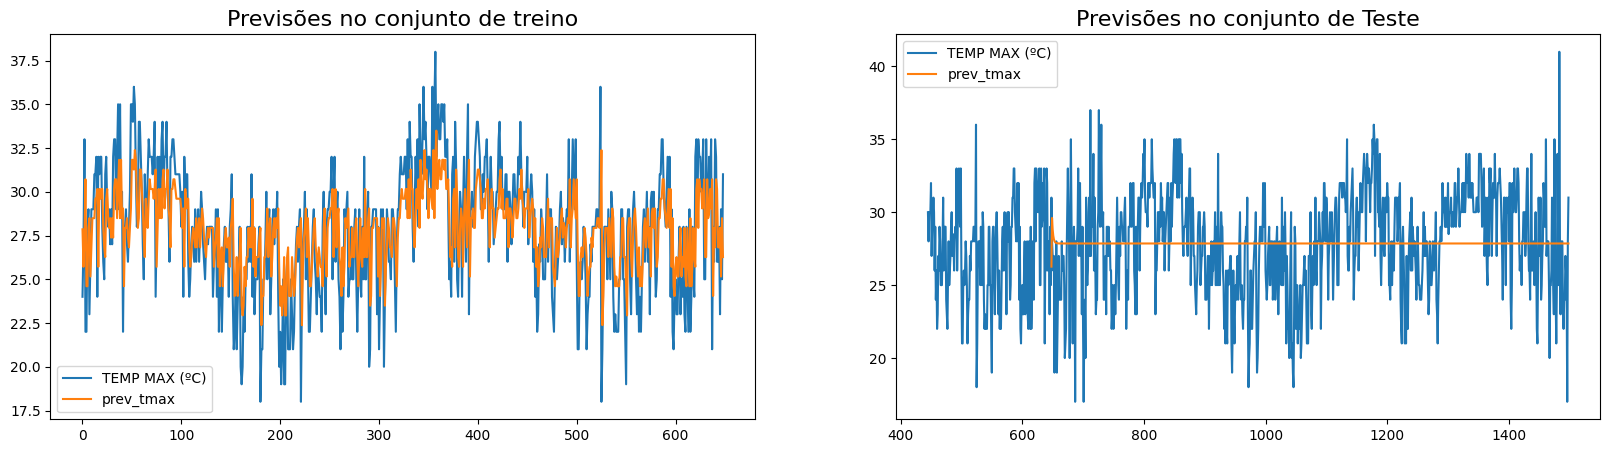

In [31]:
import matplotlib.pyplot as plt

# Construindo gráficos para as previsões no treino e no teste
fig, ax = plt.subplots(1,2,figsize=(20,5))
temp_treino[['Data']].astype(str), temp_treino[['TEMP MAX (ºC)', 'prev_tmax']].plot(ax=ax[0])
temp_teste[['Data']].astype(str), temp_teste[['TEMP MAX (ºC)', 'prev_tmax']].plot(ax=ax[1])
ax[0].set_title('Previsões no conjunto de treino',size=16)
ax[1].set_title('Previsões no conjunto de Teste',size=16)

Esse grafico abaixo foi sugerido pelo chatgpt

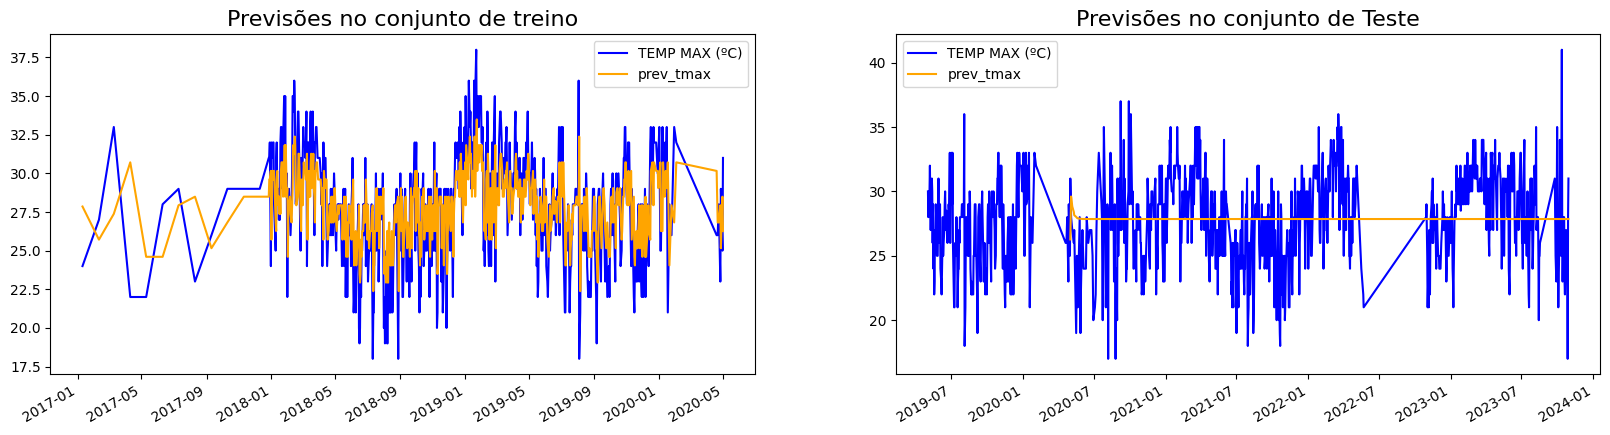

In [32]:
# Construindo gráficos para as previsões no treino e no teste
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plotando treino
ax[0].plot(temp_treino['Data'], temp_treino['TEMP MAX (ºC)'], label='TEMP MAX (ºC)', color='blue')
ax[0].plot(temp_treino['Data'], temp_treino['prev_tmax'], label='prev_tmax', color='orange')
ax[0].set_title('Previsões no conjunto de treino', size=16)

# Plotando teste
ax[1].plot(temp_teste['Data'], temp_teste['TEMP MAX (ºC)'], label='TEMP MAX (ºC)', color='blue')
ax[1].plot(temp_teste['Data'], temp_teste['prev_tmax'], label='prev_tmax', color='orange')
ax[1].set_title('Previsões no conjunto de Teste', size=16)

# Configurando as legendas
ax[0].legend()
ax[1].legend()

# Melhorar a apresentação dos ticks do eixo x para evitar sobreposição
plt.gcf().autofmt_xdate()

plt.show()

# Series Temporais dados de Pesca

In [33]:
df_pesca=pd.read_csv('pescado_nov.csv')
print(df_pesca.shape)
df_pesca.head()

(7437, 6)


,Ano,Mês,Município,Pescado,Tipo de Pesca,valor estimado no período
0,2017,1,Santos/Guarujá,Abrótea,Industrial,"R$ 785,10"
1,2017,1,Santos/Guarujá,Anequim,Industrial,"R$ 15.000,00"
2,2017,1,Santos/Guarujá,Atuns agrupados,Industrial,"R$ 1.170,00"
3,2017,1,Santos/Guarujá,Bagre,Industrial,"R$ 1.128,00"
4,2017,1,Santos/Guarujá,Bagre-amarelo,Artesanal,"R$ 38,00"


In [34]:
df_pesca.drop(['Pescado','Município'],axis=1,inplace=True)
df_pesca.head()

,Ano,Mês,Tipo de Pesca,valor estimado no período
0,2017,1,Industrial,"R$ 785,10"
1,2017,1,Industrial,"R$ 15.000,00"
2,2017,1,Industrial,"R$ 1.170,00"
3,2017,1,Industrial,"R$ 1.128,00"
4,2017,1,Artesanal,"R$ 38,00"


In [35]:
def monetario_para_float(valor_monetario):
    try:
        # Remove caracteres não numéricos
        valor_limpo = valor_monetario.replace('R$ ', '').replace('.', '').replace(',', '.').strip()
        # Converte para float
        valor_float = float(valor_limpo)
        return valor_float
    except ValueError:
        return None  # Retorne None se houver um erro na conversão

# Aplicar a função à coluna 'valor estimado no período' do DataFrame 'pescado'
df_pesca['valor estimado no período'] = df_pesca['valor estimado no período'].apply(monetario_para_float)

# Imprimir o DataFrame com os valores convertidos
df_pesca


,Ano,Mês,Tipo de Pesca,valor estimado no período
0,2017,1,Industrial,785.1
1,2017,1,Industrial,15000.0
2,2017,1,Industrial,1170.0
3,2017,1,Industrial,1128.0
4,2017,1,Artesanal,38.0
...,...,...,...,...
7432,2023,8,Industrial,35000.0
7433,2023,8,Industrial,5532.0
7434,2023,8,Industrial,14465.2
7435,2023,8,Industrial,300.0


In [36]:
# Adding a new column 'Data' by joining 'Ano' and 'Mês'
df_pesca['Data'] = df_pesca['Ano'].astype(str) + '-' + df_pesca['Mês'].astype(str).str.zfill(2)

# Grouping by 'Data' and 'Tipo de Pesca'
grouped_df = df_pesca.groupby(['Data', 'Tipo de Pesca']).sum().reset_index()

grouped_df.drop(['Ano','Mês'],inplace=True,axis=1)

print(grouped_df.shape)
grouped_df

(160, 3)


,Data,Tipo de Pesca,valor estimado no período
0,2017-01,Artesanal,522674.89
1,2017-01,Industrial,2030318.30
2,2017-02,Artesanal,868965.14
3,2017-02,Industrial,2520159.01
4,2017-03,Artesanal,129110.17
...,...,...,...
155,2023-06,Industrial,4301366.10
156,2023-07,Artesanal,999803.84
157,2023-07,Industrial,10500813.30
158,2023-08,Artesanal,800656.96


In [37]:
from statsmodels.tsa.stattools import adfuller

# Convertendo 'Data' para datetime e definindo como índice
grouped_df['Data'] = pd.to_datetime(grouped_df['Data'])
grouped_df.set_index('Data', inplace=True)

# Separando os dados em dois DataFrames, um para cada tipo de pesca
df_artesanal = grouped_df[grouped_df['Tipo de Pesca'] == 'Artesanal'].drop('Tipo de Pesca', axis=1)
df_industrial = grouped_df[grouped_df['Tipo de Pesca'] == 'Industrial'].drop('Tipo de Pesca', axis=1)



CHATGPT4

Verificação de Estacionariedade: O modelo ARIMA requer que a série temporal seja estacionária. Utilize o teste Dickey-Fuller aumentado ou outros métodos para verificar a estacionariedade.

In [38]:
# Verificando estacionariedade (usando o teste Dickey-Fuller aumentado)
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    return p_value

p_value_artesanal = test_stationarity(df_artesanal['valor estimado no período'])
p_value_industrial = test_stationarity(df_industrial['valor estimado no período'])

(p_value_artesanal, p_value_industrial)

(0.46707746774836384, 5.909353399655543e-13)

ChatGPT4


Os resultados dos valores-p obtidos a partir do teste Dickey-Fuller aumentado para as séries temporais de pesca artesanal e industrial têm implicações importantes quanto à estacionariedade dessas séries:

Pesca Artsanal (valor-p = 0.467): Este valor-p é maior que o limiar comum de 0.05, indicando que não podemos rejeitar a hipótese nula de que a série possui uma raiz unitária. Em termos simples, isso significa que a série temporal da pesca artesanal não é estacionária. Séries não estacionárias podem ter propriedades estatísticas (como média e variância) que mudam ao longo do tempo, o que pode afetar a análise e a previsão.

Pesca Industrial (valor-p ≈ 5.91e-13): Este valor-p é significativamente menor que 0.05, o que nos permite rejeitar a hipótese nula de uma raiz unitária. Portanto, concluímos que a série temporal da pesca industrial é estacionária. Uma série estacionária tem propriedades estatísticas que são constantes ao longo do tempo, o que a torna mais adequada para análise e modelagem, como com modelos ARIMA.

Implicações para Análise de Séries Temporais:
Para a pesca artesanal, será necessário aplicar técnicas como diferenciação ou transformações logarítmicas para tornar a série estacionária antes de ajustar um modelo de série temporal como o ARIMA.

Para a pesca industrial, a série já é estacionária, então podemos prosseguir com a modelagem de séries temporais sem a necessidade de diferenciação ou outras transformações para alcançar estacionariedade.

Essa etapa é crucial para garantir a adequação e precisão dos modelos de séries temporais.



In [39]:
from sklearn.model_selection import train_test_split

train_artesanal, test_artesanal = train_test_split(df_artesanal, test_size=0.2, shuffle=False)
train_industrial, test_industrial = train_test_split(df_industrial, test_size=0.2, shuffle=False)

(train_artesanal, test_artesanal, train_industrial, test_industrial)

(            valor estimado no período
 Data                                 
 2017-01-01                  522674.89
 2017-02-01                  868965.14
 2017-03-01                  129110.17
 2017-04-01                   96445.51
 2017-05-01                   67501.00
 ...                               ...
 2021-12-01                  628511.00
 2022-01-01                  611377.00
 2022-02-01                  553822.00
 2022-03-01                   12826.00
 2022-04-01                   15860.00
 
 [64 rows x 1 columns],
             valor estimado no período
 Data                                 
 2022-05-01                   10089.00
 2022-06-01                 1779756.20
 2022-07-01                 1129093.45
 2022-08-01                  994251.24
 2022-09-01                  569919.79
 2022-10-01                 1488948.80
 2022-11-01                 1228714.26
 2022-12-01                  950010.71
 2023-01-01                 1274190.98
 2023-02-01                  280085.52

ChatGPT
Para encontrar os melhores valores dos parâmetros p, d e q para os modelos ARIMA das suas séries temporais – uma para a pesca artesanal e outra para a pesca industrial (após diferenciação) – podemos usar a função auto_arima da biblioteca pmdarima. Esta função automatiza o processo de seleção de modelos ARIMA, testando diferentes combinações de p, d e q e escolhendo a que melhor se adequa aos dados com base em um critério de informação, como o AIC (Critério de Informação de Akaike).

In [40]:
# Ajustando o modelo ARIMA para pesca industrial com diferenciação
# Diferenciando a série para torná-la estacionária
df_industrial_diff = df_industrial.diff().dropna()


# Encontrando os melhores parâmetros para o modelo ARIMA da pesca artesanal
auto_model_artesanal = auto_arima(df_artesanal['valor estimado no período'], 
                                  seasonal=False, 
                                  trace=True,
                                  error_action='ignore', 
                                  suppress_warnings=True)

# Encontrando os melhores parâmetros para o modelo ARIMA da pesca industrial (diferenciada)
auto_model_industrial = auto_arima(df_industrial_diff['valor estimado no período'], 
                                   seasonal=False, 
                                   trace=True,
                                   error_action='ignore', 
                                   suppress_warnings=True)

# Melhores parâmetros encontrados para cada tipo de pesca
best_fit_artesanal = auto_model_artesanal.order
best_fit_industrial = auto_model_industrial.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2462.262, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2399.884, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2432.611, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2399.156, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2399.683, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2387.936, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2393.263, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2389.705, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2382.240, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2380.245, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2379.050, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2384.9

In [41]:
# Para a pesca artesanal
model_artesanal = ARIMA(df_artesanal['valor estimado no período'], order=best_fit_artesanal)
results_artesanal = model_artesanal.fit()
summary_artesanal = results_artesanal.summary()
print(summary_artesanal)
print('-'*100)
print('-'*100)
print('-'*100)
# Para a pesca industrial (diferenciada)
model_industrial = ARIMA(df_industrial_diff['valor estimado no período'], order=best_fit_industrial)
results_industrial = model_industrial.fit()
summary_industrial = results_industrial.summary()
print(summary_industrial)


                                   SARIMAX Results                                   
Dep. Variable:     valor estimado no período   No. Observations:                   80
Model:                        ARIMA(1, 0, 0)   Log Likelihood               -1186.243
Date:                       Mon, 13 Nov 2023   AIC                           2378.486
Time:                               19:00:20   BIC                           2385.632
Sample:                           01-01-2017   HQIC                          2381.351
                                - 08-01-2023                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.144e+05    1.6e+05      5.726      0.000    6.01e+05    1.23e+06
ar.L1          0.3147      0.137      2.293      0.022       0.046       0.

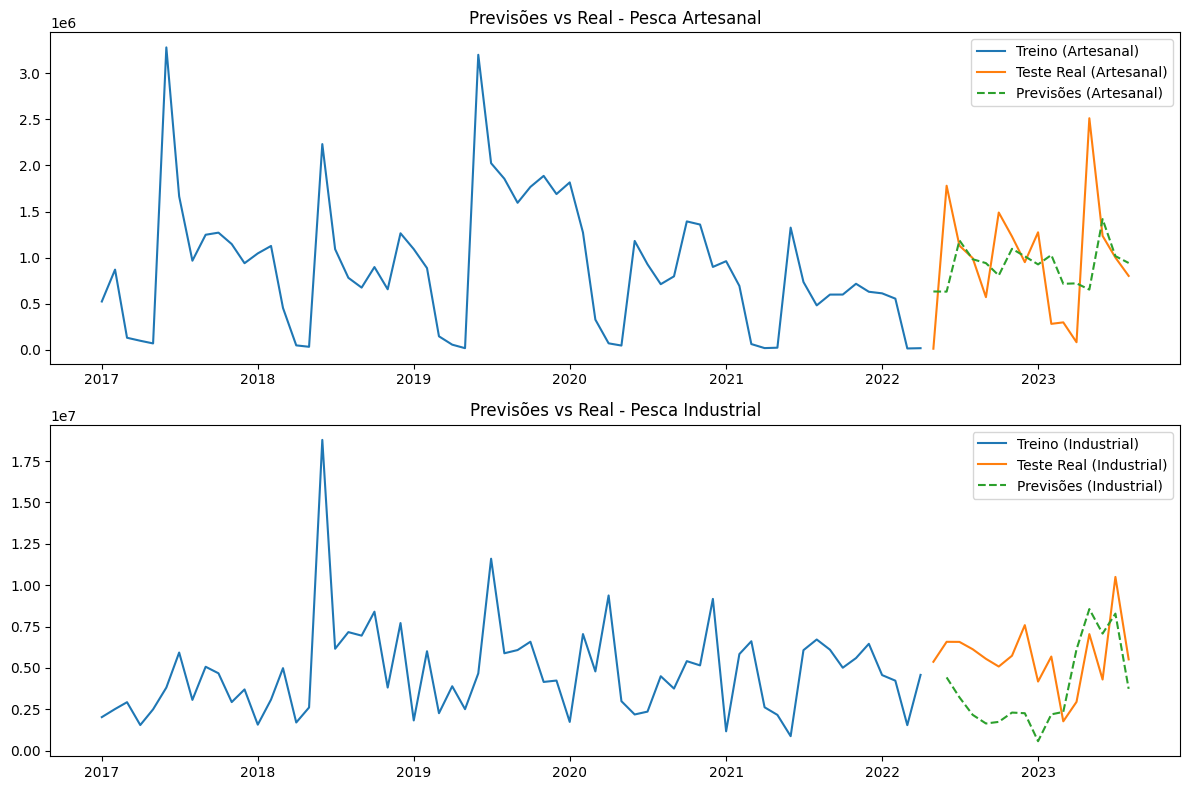

In [42]:
# Fazendo previsões para o intervalo de teste
start_artesanal = test_artesanal.index[0]
end_artesanal = test_artesanal.index[-1]

start_industrial = test_industrial.index[1]  # Começando do segundo ponto devido à diferenciação
end_industrial = test_industrial.index[-1]

predictions_artesanal = results_artesanal.predict(start=start_artesanal, end=end_artesanal)
predictions_industrial_diff = results_industrial.predict(start=start_industrial, end=end_industrial)

# Revertendo a diferenciação para previsões industriais
last_train_value = train_industrial['valor estimado no período'].iloc[-1]
predictions_industrial = last_train_value + predictions_industrial_diff.cumsum()

# Plotando os gráficos de comparação
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Pesca Artesanal
axes[0].plot(train_artesanal['valor estimado no período'], label='Treino (Artesanal)')
axes[0].plot(test_artesanal['valor estimado no período'], label='Teste Real (Artesanal)')
axes[0].plot(predictions_artesanal, label='Previsões (Artesanal)', linestyle='--')
axes[0].set_title('Previsões vs Real - Pesca Artesanal')
axes[0].legend()

# Pesca Industrial
axes[1].plot(train_industrial['valor estimado no período'], label='Treino (Industrial)')
axes[1].plot(test_industrial['valor estimado no período'], label='Teste Real (Industrial)')
axes[1].plot(predictions_industrial, label='Previsões (Industrial)', linestyle='--')
axes[1].set_title('Previsões vs Real - Pesca Industrial')
axes[1].legend()

plt.tight_layout()
plt.show()